# 从安然公司的邮件中识别欺诈行为  
## 项目描述  
在2000年，安然公司是美国最大的公司之一，到2002年时，由于广泛的公司诈骗，它已崩溃到破产边缘，在2000年,安然公司是美国最大的公司之一。到2002时，由于广泛的公司欺诈，它已崩溃到破产中。在由此产生的联邦调查中，有相当数量机密信息进入公众眼前，包括成千上万的电子邮件和详细的财务数据。安然欺诈案是一个混乱而又引人入胜的大事件，从中可以发现几乎所有想像得到的企业违法行为。

在这个项目中，我将使用Python机器学习库：scikit-learn 和安然电子邮件和财务数据，来建立模型，识别欺诈行为。

本项目将运用到以下知识：

# 特征缩放和特征选择
## 安然数据集


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from feature_format import featureFormat
from feature_format import targetFeatureSplit

#第一个特征是poi
feature_list=['poi']

#加载数据集
data_dict=pickle.load(open("final_project_dataset.pkl",'rb'))

In [9]:
print("There are",len(data_dict.keys()),"executive in enron dataset")
#print data_dict.keys()
#print data_dict['BUY RICHARD B']

('There are', 146, 'executive in enron dataset')


原始数据集包含146条记录（人），14个财务数据特征，6个电子邮件特征，1个类标号（POI）；一共有18人被标记为嫌疑人（POI）

首先，我想看看我的数据，并检查它的异常值。我绘画了安然公司员工的工资和奖金散点图，并看到了数据中的一个孤立点。

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


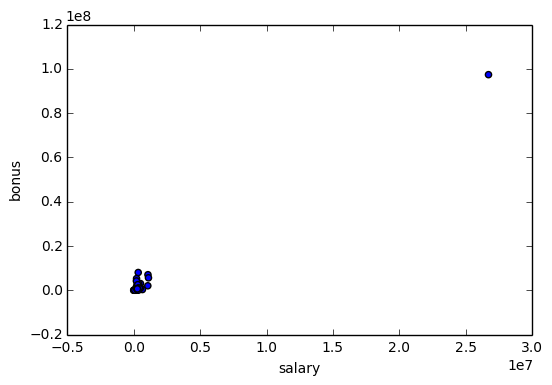

In [12]:
features=['salary','bonus']
data=featureFormat(data_dict,features)

for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

查询数据集后，发现异常值是一个总工资和奖金的数字，即把total当做一个员工，实际上total是各个财务特征的总和，因此决定手动删除它，还发现还要两个离群值（SKILLING JEFFREY和LAY KENNETH），但我保留这些值，其实这已经标志着这两个经理参与诈骗。现在数据集看起来像这样：

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037), ('WHALLEY LAWRENCE G', 510364), ('DERRICK JR. JAMES V', 492375), ('FASTOW ANDREW S', 440698), ('SHERRIFF JOHN R', 428780), ('RICE KENNETH D', 420636), ('CAUSEY RICHARD A', 415189)]


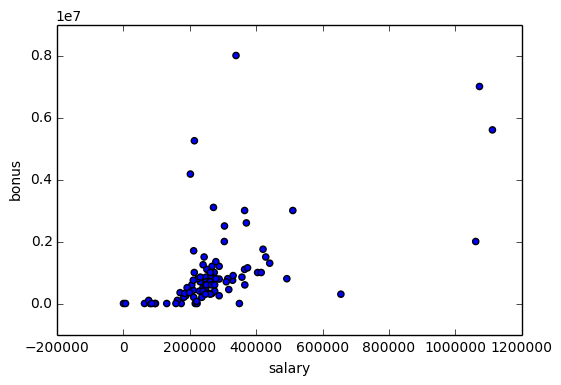

In [17]:
# 去除异常值
features=['salary','bonus']
data_dict.pop('TOTAL',0)
data=featureFormat(data_dict,features)

### 删除数据集中的NAN
outliers=[]
for key in data_dict:
    val=data_dict[key]['salary']
    if val=='NaN':
        continue
    outliers.append((key,int(val)))
outliers_final=(sorted(outliers,key=lambda x:x[1],reverse=True)[:10])
print outliers_final

# plot features
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary,bonus)

plt.xlabel('salary')
plt.ylabel('bonus')
plt.show()

## 特征选择  
清理后的数据从离群点，不得不凭感觉选择有用的特征.首先，选择特征from this person to poi和this person from poi，应该与是否为POI和有关系，于是画出这两个特征的散点图：

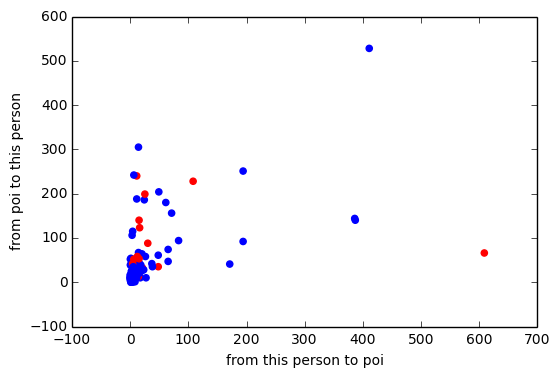

In [19]:
feature_list=['poi','from_this_person_to_poi','from_poi_to_this_person']
# 保存清理离群点后的数据
my_dataset=data_dict

# 原数据集为字典类型，python字典不能直接读入到sklearn分类或回归算法中，我编写了一些辅助函数`featureFormat()`，
# 它可以获取特征名的列表和数据字典，然后返回`numpy`数组,如果特征没有某个特定人员的值(即NaN)，此函数还会用 0替换特征值。
data=featureFormat(my_dataset,feature_list)

###plot new features
for point in data:
    from_poi=point[1]
    to_poi=point[2]
    if point[0]==1:
        plt.scatter(from_poi,to_poi,color='r')
    else:
        plt.scatter(from_poi,to_poi,color='b')
plt.xlabel('from this person to poi')
plt.ylabel('from poi to this person')
plt.show()

从绘制出的散点图来看，特征from this person to poi和this person from poi并没有很强的关系可以挖掘，以区分是否为poi

In [24]:
#创建新特征
#fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]
    for i in data_dict:
        if data_dict[i][key]=='NaN' or data_dict[i][normalizer]=='NaN':
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

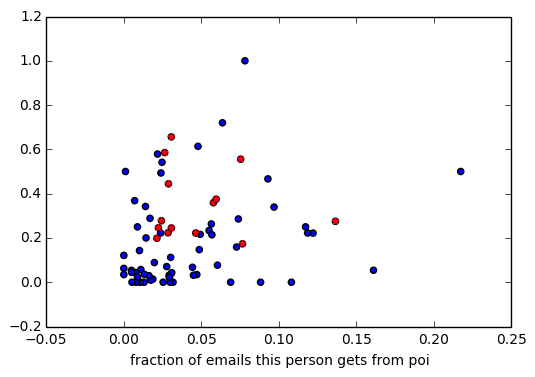

In [25]:
### insert new features into data_dict
count= 0
for i in data_dict:
    data_dict[i]['fraction_from_poi_email']=fraction_from_poi_email[count]
    data_dict[i]['fraction_to_poi_email']=fraction_to_poi_email[count]
    count+=1
    
features_list=["poi",'fraction_from_poi_email','fraction_to_poi_email']
my_dataset=data_dict
### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()


从这个新的散点图，我们似乎可以发现红色的数据点(POI)聚集在散点图中心。  
  
为离找到最有效的特征进行分类，使用“决策树”的特征选择重要性排名。选择功能是半手动迭代过程。我先把所有可能的功能为features_list然后开始删除逐一用评分值和人的直觉。

In [26]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)
labels,features=targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train,features_test,labels_train,labels_test=cross_validation.train_test_split(features,labels)